<a href="https://colab.research.google.com/github/SanyaKapoor/Classification/blob/main/MoA_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
!export KAGGLE_USERNAME=sanyakapoor
!export KAGGLE_KEY=9004f54099bb4b2f057a7704d6c1d000

In [3]:
from google.colab import files
u = files.upload()

Saving kaggle.json to kaggle.json


In [5]:
!mv "kaggle.json" "/root/.kaggle/"

In [6]:
!kaggle competitions download -c lish-moa

 98% 9.00M/9.16M [00:00<00:00, 69.0MB/s]
100% 9.16M/9.16M [00:00<00:00, 58.8MB/s]
  0% 0.00/38.9k [00:00<?, ?B/s]
100% 38.9k/38.9k [00:00<00:00, 39.1MB/s]
  0% 0.00/535k [00:00<?, ?B/s]
100% 535k/535k [00:00<00:00, 163MB/s]
  0% 0.00/233k [00:00<?, ?B/s]
100% 233k/233k [00:00<00:00, 196MB/s]
  0% 0.00/257k [00:00<?, ?B/s]
100% 257k/257k [00:00<00:00, 84.3MB/s]
 73% 40.0M/54.8M [00:00<00:00, 141MB/s]
100% 54.8M/54.8M [00:00<00:00, 218MB/s]


In [7]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from tensorflow.keras import layers,regularizers,Sequential,Model,backend,callbacks,optimizers,metrics,losses
import tensorflow as tf
import sys
import json
sys.path.append('../input/iterative-stratification/iterative-stratification-master')

In [8]:
!pip install iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [9]:
!ls

sample_data		   train_features.csv.zip
sample_submission.csv.zip  train_targets_nonscored.csv.zip
test_features.csv.zip	   train_targets_scored.csv.zip
train_drug.csv


In [10]:
!unzip sample_submission.csv.zip

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   


In [11]:
!unzip test_features.csv.zip

Archive:  test_features.csv.zip
  inflating: test_features.csv       


In [12]:
!unzip train_features.csv.zip
!unzip train_targets_nonscored.csv.zip
!unzip train_targets_scored.csv.zip

Archive:  train_features.csv.zip
  inflating: train_features.csv      
Archive:  train_targets_nonscored.csv.zip
  inflating: train_targets_nonscored.csv  
Archive:  train_targets_scored.csv.zip
  inflating: train_targets_scored.csv  


In [14]:
from google.colab import files
json_file_path = files.upload()

Saving main_predictors.json to main_predictors.json


In [15]:
# Import train data, drop sig_id, cp_type

train_features = pd.read_csv('train_features.csv')
non_ctl_idx = train_features.loc[train_features['cp_type']!='ctl_vehicle'].index.to_list()
train_features = train_features.drop(['sig_id','cp_type','cp_dose','cp_time'],axis=1)
train_targets_scored = pd.read_csv('train_targets_scored.csv')
train_targets_scored = train_targets_scored.drop('sig_id',axis=1)
labels_train = train_targets_scored.values

# Drop training data with ctl vehicle

train_features = train_features.iloc[non_ctl_idx]
labels_train = labels_train[non_ctl_idx]

# Import test data


test_features = pd.read_csv('test_features.csv')
test_features = test_features.drop(['sig_id','cp_dose','cp_time'],axis=1)
json_file_path = "main_predictors.json"

with open(json_file_path, 'r') as j:
    predictors = json.loads(j.read())
    predictors = predictors['start_predictors']

In [16]:
cs = train_features.columns.str.contains('c-')
gs = train_features.columns.str.contains('g-')

def preprocessor(train,test):
    
    # PCA
    
    n_gs = 2 # No of PCA comps to include
    n_cs = 100 # No of PCA comps to include
    
    pca_cs = PCA(n_components = n_cs)
    pca_gs = PCA(n_components = n_gs)

    train_pca_gs = pca_gs.fit_transform(train[:,gs])
    train_pca_cs = pca_cs.fit_transform(train[:,cs])
    test_pca_gs = pca_gs.transform(test[:,gs])
    test_pca_cs = pca_cs.transform(test[:,cs])
    
    # c-mean, g-mean
    
    train_c_mean = train[:,cs].mean(axis=1)
    test_c_mean = test[:,cs].mean(axis=1)
    train_g_mean = train[:,gs].mean(axis=1)
    test_g_mean = test[:,gs].mean(axis=1)
    
    # Append Features
    
    train = np.concatenate((train,train_pca_gs,train_pca_cs,train_c_mean[:,np.newaxis]
                            ,train_g_mean[:,np.newaxis]),axis=1)
    test = np.concatenate((test,test_pca_gs,test_pca_cs,test_c_mean[:,np.newaxis],
                           test_g_mean[:,np.newaxis]),axis=1)
    
    # Scaler for numerical values

    # Scale train data
    scaler = preprocessing.StandardScaler()

    train = scaler.fit_transform(train)

    # Scale Test data
    test = scaler.transform(test)
    
    return train, test

In [17]:
n_labels = train_targets_scored.shape[1]
n_train = train_features.shape[0]
n_test = test_features.shape[0]


# Prediction Clipping Thresholds

p_min = 0.0005
p_max = 0.9995

# OOF Evaluation Metric with clipping and no label smoothing

def logloss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred,p_min,p_max)
    return -backend.mean(y_true*backend.log(y_pred) + (1-y_true)*backend.log(1-y_pred))

In [18]:
def build_model(n_features, n_features_2, n_labels, label_smoothing = 0.0005):    
    input_1 = layers.Input(shape = (n_features,), name = 'Input1')
    input_2 = layers.Input(shape = (n_features_2,), name = 'Input2')

    head_1 = Sequential([
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(512, activation="elu"), 
        layers.BatchNormalization(),
        layers.Dense(256, activation = "elu")
        ],name='Head1') 

    input_3 = head_1(input_1)
    input_3_concat = layers.Concatenate()([input_2, input_3])

    head_2 = Sequential([
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(512, "relu"),
        layers.BatchNormalization(),
        layers.Dense(512, "elu"),
        layers.BatchNormalization(),
        layers.Dense(256, "relu"),
        layers.BatchNormalization(),
        layers.Dense(256, "elu")
        ],name='Head2')

    input_4 = head_2(input_3_concat)
    input_4_avg = layers.Average()([input_3, input_4]) 

    head_3 = Sequential([
        layers.BatchNormalization(),
        layers.Dense(256, kernel_initializer='lecun_normal', activation='selu'),
        layers.BatchNormalization(),
        layers.Dense(n_labels, kernel_initializer='lecun_normal', activation='selu'),
        layers.BatchNormalization(),
        layers.Dense(n_labels, activation="sigmoid")
        ],name='Head3')

    output = head_3(input_4_avg)


    model = Model(inputs = [input_1, input_2], outputs = output)
    model.compile(optimizer='adam', loss=losses.BinaryCrossentropy(label_smoothing=label_smoothing), metrics=logloss)
    
    return model

In [19]:
n_seeds = 7
np.random.seed(1)
seeds = np.random.randint(0,100,size=n_seeds)

# Training Loop

n_folds = 10
y_pred = np.zeros((n_test,n_labels))
oof = tf.constant(0.0)
hists = []
for seed in seeds:
    fold = 0
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=seed)
    for train, test in kf.split(train_features):
        X_train, X_test = preprocessor(train_features.iloc[train].values,
                                       train_features.iloc[test].values)
        _,data_test = preprocessor(train_features.iloc[train].values,
                                   test_features.drop('cp_type',axis=1).values)
        X_train_2 = train_features.iloc[train][predictors].values
        X_test_2 = train_features.iloc[test][predictors].values
        data_test_2 = test_features[predictors].values
        y_train = labels_train[train]
        y_test = labels_train[test]
        n_features = X_train.shape[1]
        n_features_2 = X_train_2.shape[1]

        model = build_model(n_features, n_features_2, n_labels)
        
        reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_logloss', factor=0.1, patience=2, mode='min', min_lr=1E-5)
        early_stopping = callbacks.EarlyStopping(monitor='val_logloss', min_delta=1E-5, patience=10, mode='min',restore_best_weights=True)

        hist = model.fit([X_train,X_train_2],y_train, batch_size=128, epochs=192,verbose=0,validation_data = ([X_test,X_test_2],y_test),
                         callbacks=[reduce_lr, early_stopping])
        hists.append(hist)
        
        # Save Model
        model.save('TwoHeads_seed_'+str(seed)+'_fold_'+str(fold))

        # OOF Score
        y_val = model.predict([X_test,X_test_2])
        oof += logloss(tf.constant(y_test,dtype=tf.float32),tf.constant(y_val,dtype=tf.float32))/(n_folds*n_seeds)

        # Run prediction
        y_pred += model.predict([data_test,data_test_2])/(n_folds*n_seeds)

        fold += 1

INFO:tensorflow:Assets written to: TwoHeads_seed_37_fold_2/assets
INFO:tensorflow:Assets written to: TwoHeads_seed_37_fold_3/assets
INFO:tensorflow:Assets written to: TwoHeads_seed_37_fold_4/assets
INFO:tensorflow:Assets written to: TwoHeads_seed_37_fold_5/assets
INFO:tensorflow:Assets written to: TwoHeads_seed_37_fold_6/assets
INFO:tensorflow:Assets written to: TwoHeads_seed_37_fold_7/assets
INFO:tensorflow:Assets written to: TwoHeads_seed_37_fold_8/assets
INFO:tensorflow:Assets written to: TwoHeads_seed_37_fold_9/assets
INFO:tensorflow:Assets written to: TwoHeads_seed_12_fold_0/assets
INFO:tensorflow:Assets written to: TwoHeads_seed_12_fold_1/assets
INFO:tensorflow:Assets written to: TwoHeads_seed_12_fold_2/assets
INFO:tensorflow:Assets written to: TwoHeads_seed_12_fold_3/assets
INFO:tensorflow:Assets written to: TwoHeads_seed_12_fold_4/assets
INFO:tensorflow:Assets written to: TwoHeads_seed_12_fold_5/assets
INFO:tensorflow:Assets written to: TwoHeads_seed_12_fold_6/assets
INFO:tenso

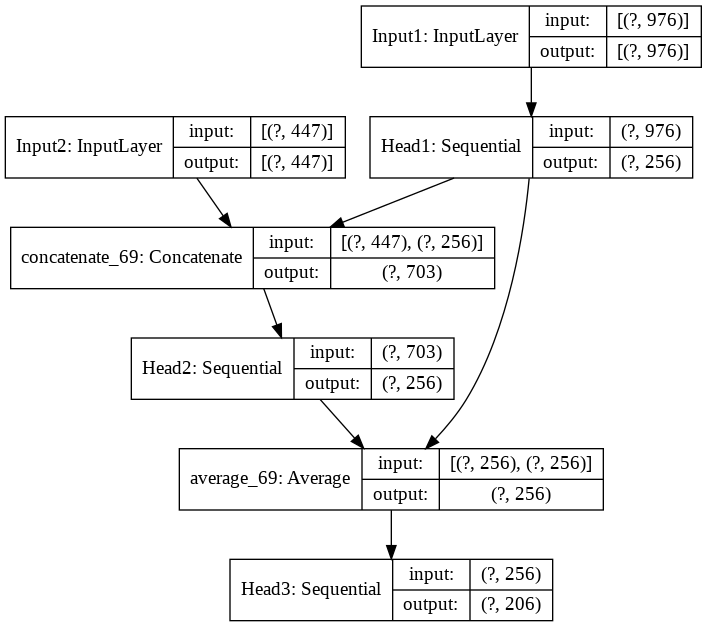

In [20]:
# Model Architecture

tf.keras.utils.plot_model(model,show_shapes=True)

OOF score is  0.0165801253


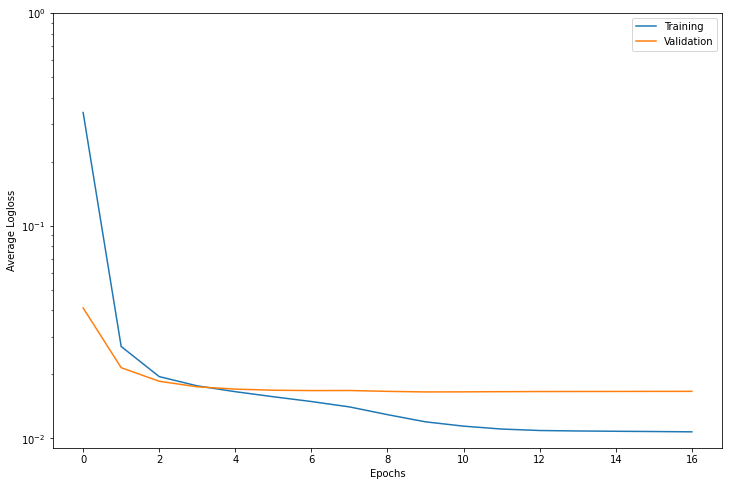

In [22]:


tf.print('OOF score is ',oof)

plt.figure(figsize=(12,8))

hist_trains = []
hist_lens = []
for i in range(n_folds*n_seeds):
    hist_train = (hists[i]).history['logloss']
    hist_trains.append(hist_train)
    hist_lens.append(len(hist_train))
hist_train = []
for i in range(min(hist_lens)):
    hist_train.append(np.mean([hist_trains[j][i] for j in range(n_folds*n_seeds)]))

plt.plot(hist_train)

hist_vals = []
hist_lens = []
for i in range(n_folds*n_seeds):
    hist_val = (hists[i]).history['val_logloss']
    hist_vals.append(hist_val)
    hist_lens.append(len(hist_val))
hist_val = []
for i in range(min(hist_lens)):
    hist_val.append(np.mean([hist_vals[j][i] for j in range(n_folds*n_seeds)]))

plt.plot(hist_val)

plt.yscale('log')
plt.yticks(ticks=[1,1E-1,1E-2])
plt.xlabel('Epochs')
plt.ylabel('Average Logloss')
plt.legend(['Training','Validation'])

In [24]:
# Generate submission file, Clip Predictions

sub = pd.read_csv('sample_submission.csv')
sub.iloc[:,1:] = np.clip(y_pred,p_min,p_max)

# Set ctl_vehicle to 0
sub.iloc[test_features['cp_type'] == 'ctl_vehicle',1:] = 0

# Save Submission
sub.to_csv('submission.csv', index=False)